# Regressing out cofounders

In this step we will take our pre-processed data set, and regress out sources of variation.

In [1]:
import os

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

import collections
%matplotlib inline

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/usr/local/lib/python3.6/dist-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


Load the AnnData matrix from the previous step. Create views for this AnnData matrix for each batch. Some of the automatically computed annotations (e.g. `n_cells` and `n_genes`) are not valid anymore, so let's remove them from the matrices.

In [2]:
adata = anndata.read_h5ad(os.path.join("write", "tgfb1-2.h5ad"))

In [3]:
batches = {batch : adata[adata.obs["batch"] == batch, :] for batch in set(adata.obs["batch"])}

In [4]:
batch_order_new_names = {"control": "CONTROL", "BMP9": "BMP-9", "TGFB1": "TGF-β₁", "BMP9-TGFB1": "meeemsBMP-9 + TGF-β₁"}

In [5]:
for batch in batches.values():
    del batch.var["n_cells"]
    del batch.obs["n_genes"]

In [6]:
for key in batch_order_new_names.keys():
    batches[key] = batches.pop(key)

In [7]:
batches

{'control': View of AnnData object with n_obs × n_vars = 1463 × 4606 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'BMP9': View of AnnData object with n_obs × n_vars = 1147 × 4606 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'TGFB1': View of AnnData object with n_obs × n_vars = 1816 × 4606 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'BMP9-TGFB1

In [8]:
for key, value in batch_order_new_names.items():
    print(key, value)
    batches[key].obs["batch"].str.replace(key, value)
    print(adata.obs["batch"])
    adata.obs["batch"] = adata.obs["batch"].str.replace(key, value)
    print(adata.obs["batch"])

control CONTROL
index
GGTGGCTGTGTTCCTC-1-control          control
GGTTGTAGTGGTCTTA-1-control          control
CGTGTCTTCATGCCGG-1-control          control
ACACCAATCGCAGTCG-1-control          control
GGCTTGGTCGGATTAC-1-control          control
                                    ...    
AGAACCTGTCCTTGTC-1-BMP9-TGFB1    BMP9-TGFB1
AACCTGAGTAAGGTCG-1-BMP9-TGFB1    BMP9-TGFB1
TTGGATGAGAGCATTA-1-BMP9-TGFB1    BMP9-TGFB1
AAAGTCCTCCTTCACG-1-BMP9-TGFB1    BMP9-TGFB1
CATTGCCTCCACTAGA-1-BMP9-TGFB1    BMP9-TGFB1
Name: batch, Length: 6189, dtype: category
Categories (4, object): [control, TGFB1, BMP9, BMP9-TGFB1]
index
GGTGGCTGTGTTCCTC-1-control          CONTROL
GGTTGTAGTGGTCTTA-1-control          CONTROL
CGTGTCTTCATGCCGG-1-control          CONTROL
ACACCAATCGCAGTCG-1-control          CONTROL
GGCTTGGTCGGATTAC-1-control          CONTROL
                                    ...    
AGAACCTGTCCTTGTC-1-BMP9-TGFB1    BMP9-TGFB1
AACCTGAGTAAGGTCG-1-BMP9-TGFB1    BMP9-TGFB1
TTGGATGAGAGCATTA-1-BMP9-TGFB1    B

## Scale data set

Gene variance alone could be a source of noise during analysis. We will scale the data set to achieve unit variance and zero mean, clipping values exceeding std 10.

In [9]:
m = np.matrix([[1, 2], [3, 4]])

In [10]:
m

matrix([[1, 2],
        [3, 4]])

In [11]:
m.sum(axis=0)

matrix([[4, 6]])

In [12]:
for batch, matrix in batches.items():
    print("Scaling batch", batch)
    sc.pp.scale(matrix, max_value=10)

Scaling batch control
Scaling batch BMP9
Scaling batch TGFB1


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Scaling batch BMP9-TGFB1


In [13]:
for batch, matrix in batches.items():
    print("After scaling", batches[batch].X.sum(axis=0)[:10])

After scaling [-6.71360493e-01 -1.20162964e-04  4.59922478e-04 -8.99284649e+00
 -1.16765499e-04  3.51920724e-04  9.02414322e-05 -1.18312240e-03
 -4.75645065e-05  3.88234854e-04]
After scaling [-2.0352006e-04 -4.0820932e+00 -1.0103583e-03 -1.0694446e+01
 -2.3674965e-04 -4.5844913e-04 -3.6048889e-04  3.7848949e-04
 -2.2232533e-05  5.7905912e-05]
After scaling [-2.9922802e+00 -7.8704157e+00  7.3103607e-04 -1.5160441e-04
 -2.7624527e+01  4.1854382e-04 -1.1575222e-04 -6.9494545e-04
  2.3114681e-04 -7.4991360e+00]
After scaling [ 3.9458275e-04 -7.8892856e+00 -1.4879555e-03 -1.9164449e+00
 -1.6125166e+01  2.4312735e-04  1.0420084e-03  1.8939972e-03
 -3.7307005e+00 -6.9264426e+00]


## Principal component analysis (PCA)

In order to visualize the differentiation in our data set, we will run principal component analysis on each individual cell as a form of dimensionality reduction. We will do this for both the global data set, as well as for each individual batch.

The first graph shows the PCA plot for the entire dataset and then broken down by batches.

PCA plot for whole data set
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)


... storing 'batch' as categorical


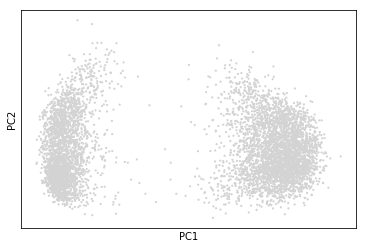

PCA plot for batch control
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


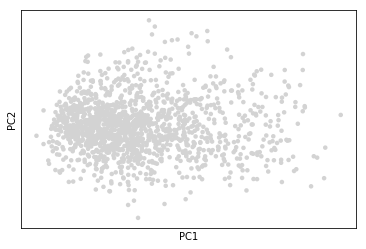

PCA plot for batch BMP9
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


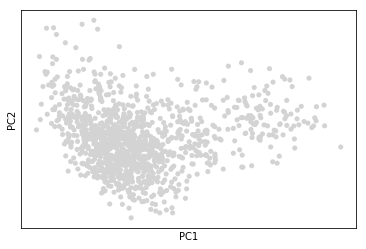

PCA plot for batch TGFB1
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


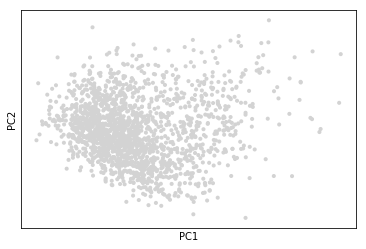

PCA plot for batch BMP9-TGFB1
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


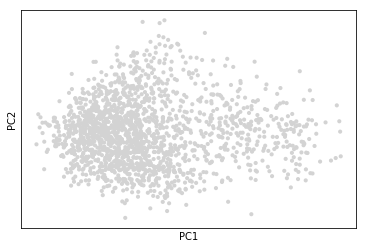

In [14]:
print("PCA plot for whole data set")
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

for batch, matrix in batches.items():
    print("PCA plot for batch", batch)
    sc.tl.pca(matrix, svd_solver='arpack')
    sc.pl.pca(matrix)

Overlay this plot with per-cell data sets to to see how these clusters vary by batch, percent of mito genes, counts, etc.

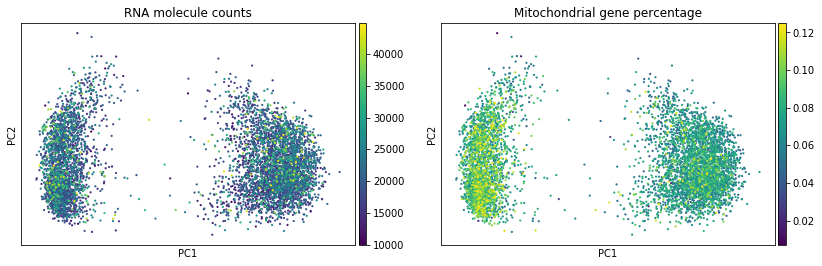

Plots for batch control


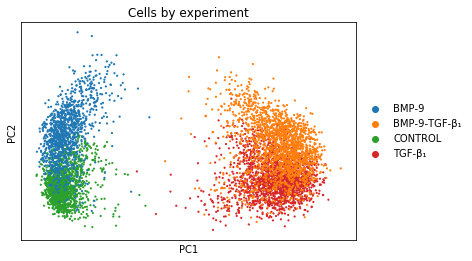

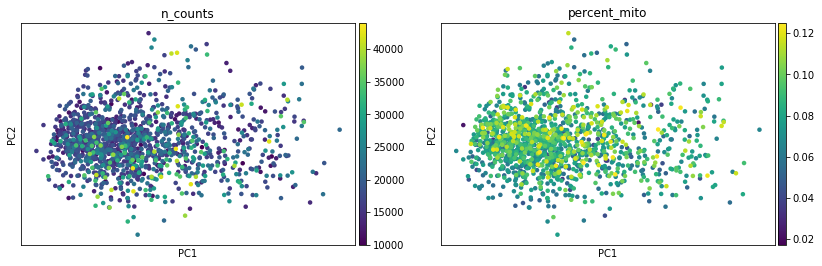

Plots for batch BMP9


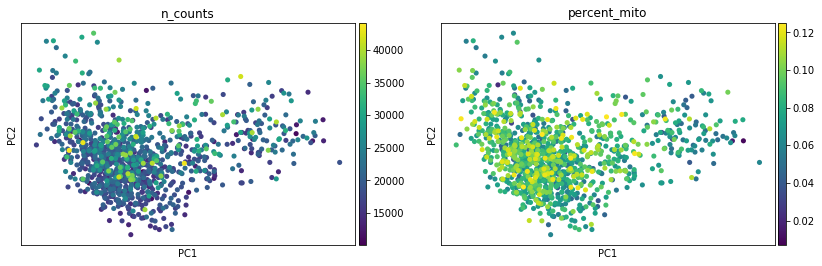

Plots for batch TGFB1


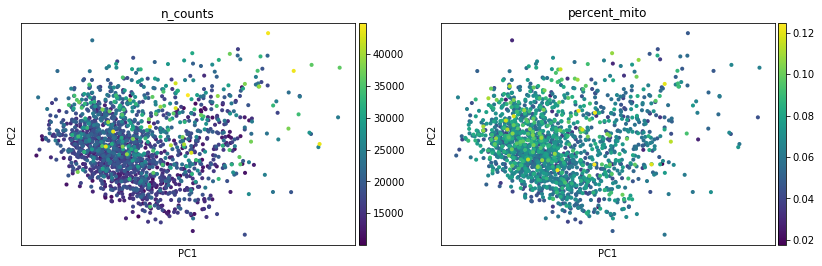

Plots for batch BMP9-TGFB1


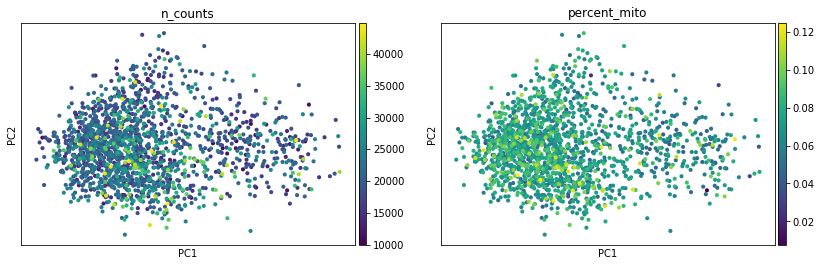

In [15]:
pca_data_points = ["n_counts", "percent_mito"]

sc.pl.pca(adata, color=pca_data_points, title=["RNA molecule counts", "Mitochondrial gene percentage"])

f = sc.pl.pca(adata, color="batch", title="Cells by experiment", return_fig=True)

for batch, matrix in batches.items():
    print("Plots for batch", batch)
    sc.pl.pca(matrix, color=pca_data_points)


## Regressing out cell count

There seems to be some variation in cell counts that we would like to get rid of. This can be done by using simple linear regression to control for the noise introduced by this cofounder. Since we have two clusters, we will want to run this process on each batch individually, rather than the matrix containing both.

In [16]:
for key, matrix in batches.items():
    print(key)
    matrix = matrix[:,[not i for i in matrix.X.sum(axis=0) == 0]]
    batches[key] = sc.pp.regress_out(matrix, ['n_counts'], copy=True)
    matrix.obs["magic"] = pd.Series(np.random.randn(len(matrix.obs.index)), index=matrix.obs.index)
    sc.pp.scale(matrix)

control
regressing out ['n_counts']
    finished (0:00:13)


Trying to set attribute `.obs` of view, making a copy.


BMP9
regressing out ['n_counts']
    finished (0:00:12)


Trying to set attribute `.obs` of view, making a copy.


TGFB1
regressing out ['n_counts']
    finished (0:00:13)


Trying to set attribute `.obs` of view, making a copy.


BMP9-TGFB1
regressing out ['n_counts']
    finished (0:00:13)


Trying to set attribute `.obs` of view, making a copy.


We should see a change in the PCA plot from before and after this took place, especially regarding the difference in total counts after regressing out that variable.

Plots for batch control after cell count regression
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


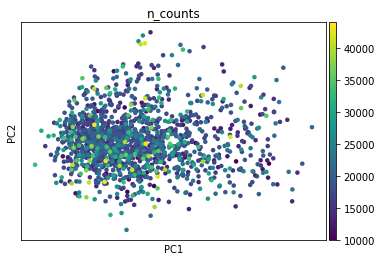

Plots for batch BMP9 after cell count regression
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


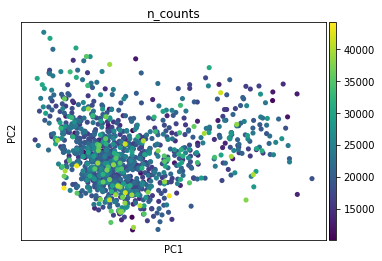

Plots for batch TGFB1 after cell count regression
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


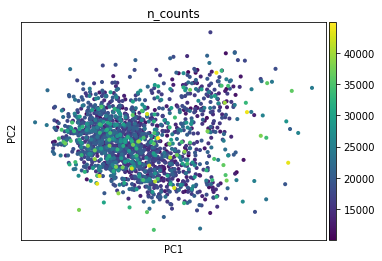

Plots for batch BMP9-TGFB1 after cell count regression
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


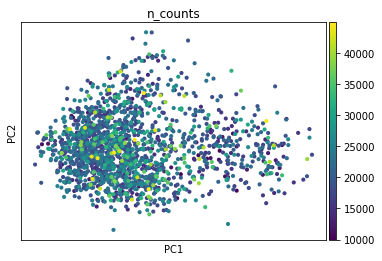

In [17]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "after cell count regression")
    sc.tl.pca(matrix, svd_solver='arpack')
    sc.pl.pca(matrix, color=['n_counts'])

## Regress out cell cycle

There is also considerable variation regarding the stage of development a cell is in at any given point. The least developed progenitor cells behave differently than the most developed differentiated cells. We mostly care about differentiation in the behavior of cells, but cells also undergo other processes that we do not want to look at and wish to control for. One of these is the cell cycle, in particular the effect that cell division has on how genes are transcribed within the cell.

We have [data](https://doi.org/10.1126/science.aad0501) of biomarkers for the S and G2M cell cycle stages. Let us use this data to compute a cell cycle score for these biomarkers and regress them out.

In [18]:
biomarkers = {}
cell_cycle_genes = set()

First, load S cycle biomarkers:

In [19]:
with open(os.path.join("data", "s_genes")) as f:
    biomarkers["S"] = set(map(str.strip, f))
    cell_cycle_genes = cell_cycle_genes.union(biomarkers["S"])

Then, load G2M cycle biomarkers:

In [20]:
with open(os.path.join("data", "g2m_genes")) as f:
    biomarkers["G2M"] = set(map(str.strip, f))
    cell_cycle_genes = cell_cycle_genes.union(biomarkers["G2M"])

Get number of genes comprising each marker:

In [21]:
{marker : len(biomarkers[marker]) for marker in biomarkers}

{'S': 43, 'G2M': 54}

Get number of all cell cycle marker genes:

In [22]:
len(cell_cycle_genes)

97

Find genes that are in the list but are not in our original list of genes. This may be due to an error in the processing that skipped a gene or different names being used in the literature. Let us correct for this.

In [23]:
cell_cycle_genes - set(adata.uns["genes_original"])

{'FAM64A', 'HN1', 'MLF1IP'}

In [24]:
cell_cycle_genes.remove("FAM64A")
cell_cycle_genes.add("PIMREG")

In [25]:
cell_cycle_genes.remove("HN1")
cell_cycle_genes.add("JPT1")

In [26]:
cell_cycle_genes.remove("MLF1IP")
cell_cycle_genes.add("CENPU")

Check which of the genes are found in each batch from each marker, then compute cell cycle score based on those sets:

In [27]:
for batch, matrix in batches.items():
    common_per_batch = {}
    
    for marker, markers in biomarkers.items():
        curr_genes = set(matrix.var.index)
        common = markers.intersection(curr_genes)
        
        print("Batch", batch, "has", len(common), "genes in common with marker", marker, ", which are", common)
        common_per_batch[marker] = common
    
    sc.tl.score_genes_cell_cycle(matrix, s_genes=common_per_batch["S"], g2m_genes=common_per_batch["G2M"])

Batch control has 10 genes in common with marker S , which are {'CHAF1B', 'ATAD2', 'CDC6', 'BRIP1', 'UHRF1', 'POLA1', 'MSH2', 'TYMS', 'HELLS', 'WDR76'}
Batch control has 19 genes in common with marker G2M , which are {'GAS2L3', 'CENPF', 'CDCA2', 'TOP2A', 'KIF2C', 'HMGB2', 'KIF11', 'TUBB4B', 'CKS2', 'TACC3', 'SMC4', 'CENPE', 'KIF20B', 'AURKA', 'TMPO', 'TPX2', 'KIF23', 'CKAP2', 'CCNB2'}
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
Batch BMP9 has 10 genes in common with marker S , which are {'CHAF1B', 'ATAD2', 'CDC6', 'BRIP1', 'UHRF1', 'POLA1', 'MSH2', 'TYMS', 'HELLS', 'WDR76'}
Batch BMP9 has 19 genes in common with marker G2M , which are {'GAS2L3', 'CENPF', 'CDCA2', 'TOP2A', 'KIF2C', 'HMGB2', 'KIF11', 'TUBB4B', 'CKS2', 'TACC3', 'SMC4', 'CENPE', 'KIF20B', '

In [28]:
batches

{'control': AnnData object with n_obs × n_vars = 1463 × 4590 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'BMP9': AnnData object with n_obs × n_vars = 1147 × 4595 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase'
     var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'genes_before_highly_variable', 'genes_original', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'
     layers: 'ambiguous', 'spliced', 'unspliced',
 'TGFB1': AnnData object with n_obs × n_vars = 1816 × 4606 
     obs: 'batch', 'cellular_barcode', 'n_counts', 'percent_mito', 'S_score', 'G2M_score', 'phase'
     var: 'gene_names', 'highly_variable', 'me

After calculating these scores, let's color our existing PCA plot by the cell cycle stages. We can see from the uniformity that this effect was controlled for during the experiment. Let's also create a separate PCA plot only for the subset of the matrix that only contains the biomarker genes:

... storing 'phase' as categorical


Plots for batch control before cell cycle regression, all genes


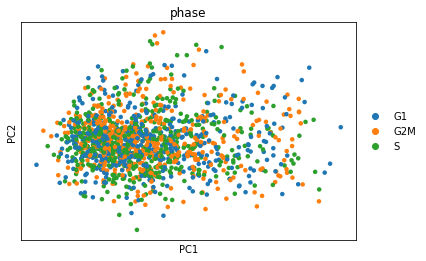

Plots for batch control before cell cycle regression, only cell cycle marker genes
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


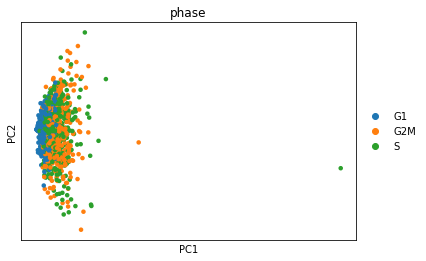

Plots for batch BMP9 before cell cycle regression, all genes


... storing 'phase' as categorical


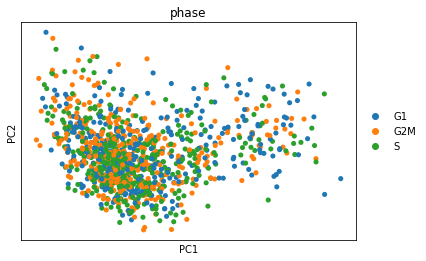

Plots for batch BMP9 before cell cycle regression, only cell cycle marker genes
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


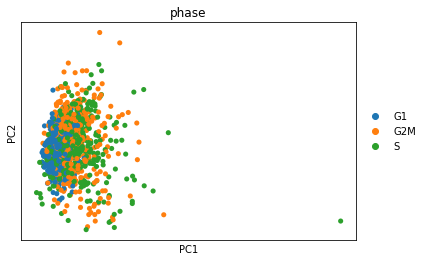

Plots for batch TGFB1 before cell cycle regression, all genes


... storing 'phase' as categorical


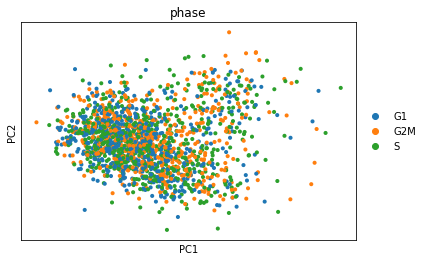

Plots for batch TGFB1 before cell cycle regression, only cell cycle marker genes
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


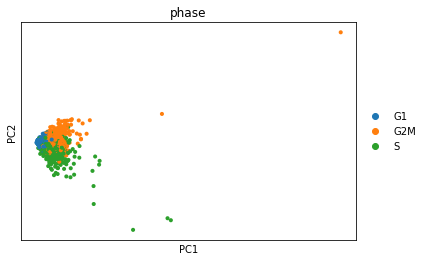

Plots for batch BMP9-TGFB1 before cell cycle regression, all genes


... storing 'phase' as categorical


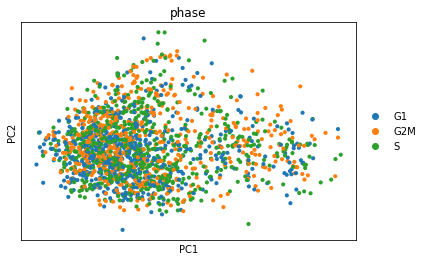

Plots for batch BMP9-TGFB1 before cell cycle regression, only cell cycle marker genes
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


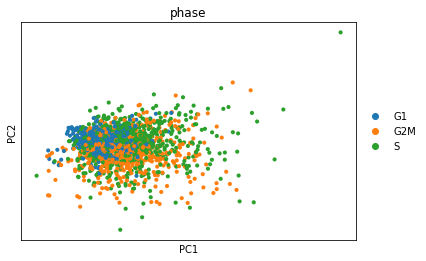

In [29]:
for batch, matrix in batches.items():
    print("Plots for batch", batch, "before cell cycle regression, all genes")
    sc.pl.pca_scatter(matrix, color='phase')
    
    print("Plots for batch", batch, "before cell cycle regression, only cell cycle marker genes")
    curr_genes = set(matrix.var.index)
    matrix_cc = matrix[:, list(cell_cycle_genes.intersection(curr_genes))]
    sc.tl.pca(matrix_cc, svd_solver='arpack')
    sc.pl.pca_scatter(matrix_cc, color='phase')

Since the cells seem to have beeen controlled for cell cycle, we will not run any regression on this data point.

## Save data to disk

Let's save the progress we have made per individual batch.

In [33]:
for batch, matrix in batches.items():
    filename = "tgfb1-3-" + batch + ".h5ad"
    filename = os.path.join("write", filename)
    matrix.write(filename)